<a href="https://colab.research.google.com/github/Riccardoboiani/Macroeconomic-PD-Satellite-Model/blob/main/Macroeconomic_Satellite_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(readxl)
library(data.table)
library(dplyr)
library(lubridate)

# --- 1. CARICAMENTO E PULIZIA ---
# Carichiamo il file grezzo
df_macro <- read_excel("Macroeconomic satellite Model.xlsx")
# Rinominiamo le colonne per facilità (togliamo spazi e caratteri strani)
colnames(df_macro) <- c("Date", "Default_Rate", "GDP_YoY", "CPI_YoY", "Unemployment", "RPI_YoY", "BTP_10Y")

# Gestione Date:
df_macro$Date <- as.Date(df_macro$Date, format = "%d/%m/%Y")


In [ ]:

# --- 2.LOGIT TRANSFORMATION --> Z ---
# Formula dal testo: y_t = ln( Y_t / (1 - Y_t) )
# Dove Y_t è il Default Rate
df_macro$Z_Index <- log(df_macro$Default_Rate / (1 - df_macro$Default_Rate))

# --- 3. CREAZIONE DEI LAG (PER IL MODELLO ARDL) ---
# Significa che dobbiamo creare i ritardi sia per la Y (Z_Index) che per le X (Macro).
# Creiamo lags fino a 4 trimestri (1 anno), che è standard per questi modelli.

# A. Lags della Variabile Dipendente (Parte Autoregressiva)
df_macro$Z_Lag1 <- shift(df_macro$Z_Index, n=1, type="lag")
df_macro$Z_Lag2 <- shift(df_macro$Z_Index, n=2, type="lag")
df_macro$Z_Lag3 <- shift(df_macro$Z_Index, n=3, type="lag")
df_macro$Z_Lag4 <- shift(df_macro$Z_Index, n=4, type="lag")

# B. Lags delle Variabili Macro (Parte Distributed Lag)
macro_vars <- c("GDP_YoY", "CPI_YoY", "Unemployment", "RPI_YoY", "BTP_10Y")

for(var in macro_vars) {
  df_macro[[paste0(var, "_Lag1")]] <- shift(df_macro[[var]], n=1, type="lag")
  df_macro[[paste0(var, "_Lag2")]] <- shift(df_macro[[var]], n=2, type="lag")
  df_macro[[paste0(var, "_Lag3")]] <- shift(df_macro[[var]], n=3, type="lag")
  df_macro[[paste0(var, "_Lag4")]] <- shift(df_macro[[var]], n=4, type="lag")
}

# Rimuoviamo le prime 4 righe che ora contengono NA (a causa dei lag)
df_model_ready <- na.omit(df_macro)

# --- 4. CONTROLLO ---
print("Prime 5 righe del dataset pronto per la stima:")
print(head(df_model_ready[, c("Date", "Default_Rate", "Z_Index", "Z_Lag1", "GDP_YoY", "GDP_YoY_Lag1")]))
print(summary(df_model_ready$Z_Index))

# --- 1. SETUP LIBRERIE ---
if (!require("lmtest")) install.packages("lmtest")   # Per Ljung-Box test
if (!require("tseries")) install.packages("tseries") # Per Jarque-Bera test
if (!require("car")) install.packages("car")         # Per VIF (Collinearità)

library(utils)
library(lmtest)
library(tseries)
library(car)



[1] "Prime 5 righe del dataset pronto per la stima:"
# A tibble: 6 × 6
  Date       Default_Rate Z_Index Z_Lag1   GDP_YoY GDP_YoY_Lag1
  <date>            <dbl>   <dbl>  <dbl>     <dbl>        <dbl>
1 2007-06-30       0.0146   -4.21  -4.19  0.0150       0.0183  
2 2007-09-30       0.0151   -4.18  -4.21 -0.000819     0.0150  
3 2007-12-31       0.0153   -4.16  -4.18  0.0111      -0.000819
4 2008-03-31       0.0156   -4.14  -4.16 -0.000769     0.0111  
5 2008-06-30       0.0170   -4.06  -4.14 -0.0156      -0.000769
6 2008-09-30       0.0210   -3.84  -4.06 -0.0371      -0.0156  
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -4.822  -4.489  -3.907  -3.890  -3.265  -3.057 


In [ ]:
# =============================================================================
# --- TEST DI STAZIONARIETÀ (AUGMENTED DICKEY-FULLER) ---
# Obiettivo: Verificare che le variabili non abbiano "Unit Root" (Non stazionarie).
# H0 (Ipotesi Nulla): La serie NON è stazionaria (ha radice unitaria).
# H1 (Ipotesi Alternativa): La serie È stazionaria.
# Se p-value < 0.05 -> Rifiutiamo H0 -> La serie è STAZIONARIA (OK).
# =============================================================================

print("--- ESECUZIONE TEST DI STAZIONARIETÀ (ADF) ---")

# Lista di tutte le variabili da testare (Y trasformata + Macro X)
vars_to_test <- c("Z_Index", "GDP_YoY", "CPI_YoY", "Unemployment", "RPI_YoY", "BTP_10Y")

# Creiamo un dataframe vuoto per salvare i risultati
adf_results <- data.frame(
  Variable = character(),
  Test_Statistic = numeric(),
  P_Value = numeric(),
  Result = character(),
  stringsAsFactors = FALSE
)

for(var in vars_to_test) {

  # Prendiamo la serie, rimuovendo eventuali NA residui per sicurezza
  series <- na.omit(df_model_ready[[var]])

  # Eseguiamo il test ADF
  # 'k' è il numero di lag usati nel test. La funzione lo calcola in automatico,
  # ma si può fissare. Lasciamo automatico.
  adf_out <- adf.test(series, alternative = "stationary")

  # Interpretazione
  is_stationary <- adf_out$p.value < 0.05
  res_label <- ifelse(is_stationary, "STAZIONARIA (OK)", "NON STAZIONARIA (ATTENZIONE)")

  # Salviamo nella tabella
  adf_results <- rbind(adf_results, data.frame(
    Variable = var,
    Test_Statistic = round(adf_out$statistic, 4),
    P_Value = round(adf_out$p.value, 4),
    Result = res_label
  ))
}

# Visualizziamo la tabella dei risultati
print(adf_results)

# --- CHECK BLOCCANTE (OPZIONALE) ---
# Se vuoi che il codice ti avvisi chiaramente se qualcosa non va:
if(any(adf_results$P_Value > 0.05)) {
  print("!!! ATTENZIONE !!! Alcune variabili potrebbero non essere stazionarie.")
  print("Controlla la colonna 'Result' sopra. Potrebbe essere necessario differenziare (diff()) le variabili non stazionarie.")
} else {
  print("OTTIMO: Tutte le variabili sembrano stazionarie. Puoi procedere con l'ARDL.")
}

print("--------------------------------------------------")

[1] "--- ESECUZIONE TEST DI STAZIONARIETÀ (ADF) ---"
                   Variable Test_Statistic P_Value                       Result
Dickey-Fuller       Z_Index        -3.6220  0.0378             STAZIONARIA (OK)
Dickey-Fuller1      GDP_YoY        -3.7332  0.0283             STAZIONARIA (OK)
Dickey-Fuller2      CPI_YoY        -2.7153  0.2842 NON STAZIONARIA (ATTENZIONE)
Dickey-Fuller3 Unemployment        -1.5274  0.7676 NON STAZIONARIA (ATTENZIONE)
Dickey-Fuller4      RPI_YoY        -2.4899  0.3759 NON STAZIONARIA (ATTENZIONE)
Dickey-Fuller5      BTP_10Y        -1.8304  0.6443 NON STAZIONARIA (ATTENZIONE)
[1] "!!! ATTENZIONE !!! Alcune variabili potrebbero non essere stazionarie."
[1] "Controlla la colonna 'Result' sopra. Potrebbe essere necessario differenziare (diff()) le variabili non stazionarie."
[1] "--------------------------------------------------"


In [ ]:
# =============================================================================
# --- 5-TER. CORREZIONE NON STAZIONARIETÀ (DIFFERENZE PRIME) ---
# Le variabili che non hanno passato il test vengono trasformate in differenze:
# X_t diventa Delta_X_t = X_t - X_{t-1}
# =============================================================================

# 1. Creiamo le nuove variabili differenziate (prefisso "D_")
# Usiamo c(NA, diff(...)) per mantenere la stessa lunghezza del dataframe (la prima oss diventa NA)

df_macro$D_CPI_YoY      <- c(NA, diff(df_macro$CPI_YoY))
df_macro$D_Unemployment <- c(NA, diff(df_macro$Unemployment))
df_macro$D_RPI_YoY      <- c(NA, diff(df_macro$RPI_YoY))
df_macro$D_BTP_10Y      <- c(NA, diff(df_macro$BTP_10Y))

# GDP era già stazionaria, la teniamo così com'è.
# Z_Index era già stazionaria, la teniamo così com'è.

# 2. Aggiorniamo la lista delle variabili da usare nel modello
# Sostituiamo quelle vecchie con quelle nuove differenziate
final_macro_vars <- c("GDP_YoY", "D_CPI_YoY", "D_Unemployment", "D_RPI_YoY", "D_BTP_10Y")

# 3. VERIFICA STAZIONARIETÀ SULLE NUOVE VARIABILI
print("--- RE-TEST STAZIONARIETÀ SULLE VARIABILI DIFFERENZIATE ---")

adf_results_diff <- data.frame(Variable = character(), P_Value = numeric(), Result = character())

for(var in final_macro_vars) {
  # na.omit fondamentale qui perché la differenziazione crea un NA alla riga 1
  series <- na.omit(df_macro[[var]])
  adf_out <- adf.test(series, alternative = "stationary")

  is_stationary <- adf_out$p.value < 0.05
  res_label <- ifelse(is_stationary, "STAZIONARIA (OK)", "NON STAZIONARIA")

  adf_results_diff <- rbind(adf_results_diff, data.frame(
    Variable = var,
    P_Value = round(adf_out$p.value, 4),
    Result = res_label
  ))
}

print(adf_results_diff)


[1] "--- RE-TEST STAZIONARIETÀ SULLE VARIABILI DIFFERENZIATE ---"


Warning message in adf.test(series, alternative = "stationary"):
“p-value smaller than printed p-value”
Warning message in adf.test(series, alternative = "stationary"):
“p-value smaller than printed p-value”


        Variable P_Value           Result
1        GDP_YoY  0.0235 STAZIONARIA (OK)
2      D_CPI_YoY  0.0100 STAZIONARIA (OK)
3 D_Unemployment  0.0179 STAZIONARIA (OK)
4      D_RPI_YoY  0.0100 STAZIONARIA (OK)
5      D_BTP_10Y  0.0432 STAZIONARIA (OK)


In [ ]:
# =============================================================================
# --- 4-BIS. CREAZIONE DEI LAG SULLE NUOVE VARIABILI STAZIONARIE ---
# IMPORTANTE: Ora dobbiamo creare i lag per le variabili differenziate (D_...)
# =============================================================================

# Definiamo la lista finale delle variabili da usare nel modello
# (GDP era stazionario, le altre sono le differenziate)
final_macro_vars <- c("GDP_YoY", "D_CPI_YoY", "D_Unemployment", "D_RPI_YoY", "D_BTP_10Y")

# Creiamo i lag (1 a 4) per queste variabili specifiche
for(var in final_macro_vars) {
  df_macro[[paste0(var, "_Lag1")]] <- shift(df_macro[[var]], n=1, type="lag")
  df_macro[[paste0(var, "_Lag2")]] <- shift(df_macro[[var]], n=2, type="lag")
  df_macro[[paste0(var, "_Lag3")]] <- shift(df_macro[[var]], n=3, type="lag")
  df_macro[[paste0(var, "_Lag4")]] <- shift(df_macro[[var]], n=4, type="lag")

}

# Rimuoviamo nuovamente le righe con NA (necessario dopo aver creato nuovi lag)
df_model_ready <- na.omit(df_macro)

print("Check colonne dataset:")
print(colnames(df_model_ready)) # Verifica che ci siano le colonne _Lag1, etc.


[1] "Check colonne dataset:"
 [1] "Date"                "Default_Rate"        "GDP_YoY"            
 [4] "CPI_YoY"             "Unemployment"        "RPI_YoY"            
 [7] "BTP_10Y"             "Z_Index"             "Z_Lag1"             
[10] "Z_Lag2"              "Z_Lag3"              "Z_Lag4"             
[13] "GDP_YoY_Lag1"        "GDP_YoY_Lag2"        "GDP_YoY_Lag3"       
[16] "GDP_YoY_Lag4"        "CPI_YoY_Lag1"        "CPI_YoY_Lag2"       
[19] "CPI_YoY_Lag3"        "CPI_YoY_Lag4"        "Unemployment_Lag1"  
[22] "Unemployment_Lag2"   "Unemployment_Lag3"   "Unemployment_Lag4"  
[25] "RPI_YoY_Lag1"        "RPI_YoY_Lag2"        "RPI_YoY_Lag3"       
[28] "RPI_YoY_Lag4"        "BTP_10Y_Lag1"        "BTP_10Y_Lag2"       
[31] "BTP_10Y_Lag3"        "BTP_10Y_Lag4"        "D_CPI_YoY"          
[34] "D_Unemployment"      "D_RPI_YoY"           "D_BTP_10Y"          
[37] "D_CPI_YoY_Lag1"      "D_CPI_YoY_Lag2"      "D_CPI_YoY_Lag3"     
[40] "D_CPI_YoY_Lag4"      "D_Unemployment_Lag1"

In [ ]:
#####################################################FASE UNIVARIATA

# --- 6. DEFINIZIONE SEGNI ECONOMICI ATTESI ---
# Definiamo a priori il segno atteso del Long Run Multiplier per ogni variabile.
# +1: Relazione positiva (es. Disoccupazione sale -> Default sale)
# -1: Relazione negativa (es. GDP sale -> Default scende)
economic_signs <- list(
  "GDP_YoY"        = -1, # GDP sale -> Default scende
  "D_CPI_YoY"      =  1, # Inflazione accelera -> Default sale
  "D_Unemployment" =  1, # Disoccupazione cresce -> Default sale
  "D_RPI_YoY"      =  1,
  "D_BTP_10Y"      =  1  # Tassi salgono -> Default sale
)


# Funzione per calcolare il Long Run Multiplier (LRM)
# LRM = (Somma coeff X) / (1 - Somma coeff Y_lags)
calc_lrm <- function(model, x_var_name) {
  coeffs <- coef(model)
  # Identifica coefficienti AR (Z_Lag) e DL (Macro Lag)
  ar_coeffs <- coeffs[grep("Z_Lag", names(coeffs))]
  dl_coeffs <- coeffs[grep(x_var_name, names(coeffs))] # Include lag0 e lag1..4

  sum_ar <- sum(ar_coeffs, na.rm = TRUE)
  sum_dl <- sum(dl_coeffs, na.rm = TRUE)

  # LRM calculation
  lrm <- sum_dl / (1 - sum_ar)
  return(list(lrm = lrm, sum_ar = sum_ar))
}

# --- 7. LOOP DI STIMA E SELEZIONE (GRID SEARCH) ---

# Creiamo un contenitore per i risultati
results_list <- list()
iteration <- 1

# Variabili Macro da testare
macro_vars <- final_macro_vars

# Max lag settings
max_p <- 4 # Lag autoregressivi (Y)
max_q <- 4 # Lag distribuiti (X)

print("Inizio Grid Search Univariata...")

for (var in macro_vars) {

  exp_sign <- economic_signs[[var]]

  # Loop per p (Autoregressive lags: da 1 a 4)
  for (p in 1:max_p) {

    # Loop per q (Distributed lags: da 0 a 4)
    # q=0 significa che usiamo solo la X contemporanea
    for (q in 0:max_q) {

      # 1. COSTRUZIONE FORMULA DINAMICA
      # Parte AR (Y)
      ar_terms <- paste0("Z_Lag", 1:p)

      # Parte DL (X)
      # Se q=0 prendiamo solo la var originale. Se q>0 aggiungiamo i lag.
      if (q == 0) {
        dl_terms <- var
      } else {
        dl_terms <- c(var, paste0(var, "_Lag", 1:q))
      }

      # Uniamo tutto nella formula
      rhs <- paste(c(ar_terms, dl_terms), collapse = " + ")
      f_string <- paste("Z_Index ~", rhs)

      # 2. STIMA MODELLO
      model <- lm(as.formula(f_string), data = df_model_ready)

      # 3. ESTRAZIONE STATISTICHE E TEST
      model_summ <- summary(model)

      # A. Stability Check (Sum of AR coeffs < 1)
      lrm_stats <- calc_lrm(model, var)
      stability_check <- abs(lrm_stats$sum_ar) < 1

      # B. Residual Autocorrelation (Ljung-Box)
      # H0: No autocorrelation. Vogliamo p-value > 0.05 per NON rifiutare H0.
      lb_test <- Box.test(residuals(model), type = "Ljung-Box", lag = 4) # Lag 4 standard per dati trimestrali
      resid_autocorr_ok <- lb_test$p.value > 0.05

      # C. Residual Normality (Jarque-Bera)
      # H0: Normality. Vogliamo p-value > 0.05
      jb_test <- jarque.bera.test(residuals(model))
      resid_norm_ok <- jb_test$p.value > 0.05

      # D. Economic Sign Consistency (LRM Sign)
      # Verifichiamo se il segno del LRM corrisponde all'aspettativa
      lrm_val <- lrm_stats$lrm
      sign_ok <- FALSE
      if (exp_sign == 1 && lrm_val > 0) sign_ok <- TRUE
      if (exp_sign == -1 && lrm_val < 0) sign_ok <- TRUE

      # E. Information Criteria
      aic_val <- AIC(model)
      bic_val <- BIC(model)

      # 4. SALVATAGGIO RISULTATI TEMPORANEI
      # Salviamo tutto, poi filtreremo
      results_list[[iteration]] <- data.frame(
        Variable = var,
        Lag_p = p,
        Lag_q = q,
        AIC = aic_val,
        BIC = bic_val,
        Sum_AR = lrm_stats$sum_ar,
        LRM = lrm_val,
        Stability_Pass = stability_check,
        LjungBox_Pval = lb_test$p.value,
        LjungBox_Pass = resid_autocorr_ok,
        JarqueBera_Pval = jb_test$p.value,
        JarqueBera_Pass = resid_norm_ok,
        Sign_Pass = sign_ok,
        Formula = f_string
      )
      iteration <- iteration + 1
    }
  }
}

# Uniamo tutto in un DataFrame
results_df <- do.call(rbind, results_list)

# --- 8. SELEZIONE DEL MODELLO MIGLIORE ---

# Filtriamo solo i modelli che passano TUTTI i test
valid_models <- subset(results_df,
                       Stability_Pass == TRUE &
                         LjungBox_Pass == TRUE &
                         JarqueBera_Pass == TRUE &
                         Sign_Pass == TRUE)

# Selezioniamo il migliore per ogni variabile basandoci sul BIC minimo
best_models <- valid_models %>%
  group_by(Variable) %>%
  filter(BIC == min(BIC)) %>%
  ungroup()

[1] "Inizio Grid Search Univariata..."


In [ ]:
# --- 9. OUTPUT RISULTATI ---

print("--- RIASSUNTO MODELLI VALIDI ---")
print(paste("Totale modelli testati:", nrow(results_df)))
print(paste("Modelli che hanno superato tutti i test:", nrow(valid_models)))

print("--- MIGLIOR MODELLO PER OGNI VARIABILE (MIN BIC) ---")
print(best_models[, c("Variable", "Lag_p", "Lag_q", "BIC", "LRM", "Formula")])

# Se vuoi vedere i dettagli di un modello specifico (es. il primo dei migliori)
if(nrow(best_models) > 0) {
  print("Esempio dettaglio miglior modello GDP:")
  best_gdp <- best_models[best_models$Variable == "GDP_YoY", ]
  print(best_gdp)

  # Ristima per vedere i coefficienti
  final_model <- lm(as.formula(best_gdp$Formula), data = df_model_ready)
  print(summary(final_model))
} else {
  print("ATTENZIONE: Nessun modello ha superato tutti i test statistici ed economici.")

}


[1] "--- RIASSUNTO MODELLI VALIDI ---"
[1] "Totale modelli testati: 100"
[1] "Modelli che hanno superato tutti i test: 38"
[1] "--- MIGLIOR MODELLO PER OGNI VARIABILE (MIN BIC) ---"
# A tibble: 4 × 6
  Variable       Lag_p Lag_q   BIC    LRM Formula                               
  <chr>          <int> <int> <dbl>  <dbl> <chr>                                 
1 GDP_YoY            3     0 -158. -15.9  Z_Index ~ Z_Lag1 + Z_Lag2 + Z_Lag3 + …
2 D_CPI_YoY          3     4 -143.  27.6  Z_Index ~ Z_Lag1 + Z_Lag2 + Z_Lag3 + …
3 D_Unemployment     3     0 -155. 108.   Z_Index ~ Z_Lag1 + Z_Lag2 + Z_Lag3 + …
4 D_BTP_10Y          3     3 -143.   2.29 Z_Index ~ Z_Lag1 + Z_Lag2 + Z_Lag3 + …
[1] "Esempio dettaglio miglior modello GDP:"
# A tibble: 1 × 14
  Variable Lag_p Lag_q   AIC   BIC Sum_AR   LRM Stability_Pass LjungBox_Pval
  <chr>    <int> <int> <dbl> <dbl>  <dbl> <dbl> <lgl>                  <dbl>
1 GDP_YoY      3     0 -171. -158.  0.978 -15.9 TRUE                   0.731
# ℹ 5 more variable

In [ ]:
# --- 10. VISUALIZZAZIONE DI TUTTI I 49 MODELLI VALIDI ---
# Creiamo una tabella più leggibile selezionando solo le colonne chiave
cols_to_show <- c("Variable", "Lag_p", "Lag_q", "BIC", "LRM",
                  "Sum_AR", "LjungBox_Pval", "JarqueBera_Pval")

print("--- LISTA COMPLETA DEI MODELLI VALIDI ---")
# Ordiniamo per Variabile e poi per BIC (dal migliore al peggiore)
valid_models_sorted <- valid_models[order(valid_models$Variable, valid_models$BIC), cols_to_show]
print(valid_models_sorted, row.names = FALSE)



[1] "--- LISTA COMPLETA DEI MODELLI VALIDI ---"
       Variable Lag_p Lag_q       BIC        LRM    Sum_AR LjungBox_Pval
      D_BTP_10Y     3     3 -143.1912   2.294147 0.9824072    0.56762110
      D_BTP_10Y     3     4 -140.7675 144.943800 0.9860373    0.56256017
      D_BTP_10Y     2     4 -140.0579 187.379847 0.9901044    0.24905066
      D_BTP_10Y     4     3 -139.8470   9.161414 0.9796767    0.93372615
      D_BTP_10Y     4     4 -138.0781 151.745344 0.9830834    0.94876925
      D_CPI_YoY     3     4 -143.1975  27.642121 0.9832690    0.90289966
      D_CPI_YoY     2     4 -140.9623   1.848769 0.9877058    0.29580982
      D_CPI_YoY     4     4 -139.5949  21.624174 0.9808153    0.99289470
 D_Unemployment     3     0 -155.4669 108.119764 0.9771964    0.79584214
 D_Unemployment     2     0 -153.1351 127.850058 0.9827339    0.21890087
 D_Unemployment     4     0 -152.0293 103.632190 0.9739740    0.99878452
 D_Unemployment     3     1 -151.3356 131.114448 0.9759438    0.77746224
 D_

In [ ]:
# --- 11. DETTAGLIO APPROFONDITO PER I MIGLIORI MODELLI (BEST PER OGNI VAR) ---

print(" ")
print("################################################################")
print("### REPORT DETTAGLIATO: MIGLIOR MODELLO PER CIASCUNA VARIABILE ###")
print("################################################################")

# Ciclo su ogni riga del dataframe 'best_models'
for(i in 1:nrow(best_models)) {

  # Estraiamo la riga corrente come lista/vettore
  row <- best_models[i, ]

  # Intestazione visiva
  cat("\n==========================================================\n")
  cat(paste("VARIABILE MACRO:", row$Variable))
  cat(paste("\nStruttura Lag -> AR(p):", row$Lag_p, "| DL(q):", row$Lag_q))
  cat("\n==========================================================\n")

  # 1. Stampa Diagnostiche (prese dai calcoli precedenti)
  cat("--- DIAGNOSTICA DEL MODELLO ---\n")
  cat(sprintf("BIC                 : %.4f\n", row$BIC))
  cat(sprintf("AIC                 : %.4f\n", row$AIC))
  cat(sprintf("Ljung-Box P-value   : %.4f  (Check > 0.05: %s)\n", row$LjungBox_Pval, ifelse(row$LjungBox_Pass, "OK", "FAIL")))
  cat(sprintf("Jarque-Bera P-value : %.4f  (Check > 0.05: %s)\n", row$JarqueBera_Pval, ifelse(row$JarqueBera_Pass, "OK", "FAIL")))
  cat(sprintf("Stabilità (Sum AR)  : %.4f  (Check < 1   : %s)\n", row$Sum_AR, ifelse(row$Stability_Pass, "OK", "FAIL")))
  cat(sprintf("Long Run Multiplier : %.4f  (Segno Atteso: %s)\n", row$LRM, ifelse(row$Sign_Pass, "OK", "FAIL")))

  # 2. Ristima del modello per ottenere i coefficienti
  temp_model <- lm(as.formula(row$Formula), data = df_model_ready)

  # 3. Stampa output standard R (con asterischi di significatività)
  cat("\n--- DETTAGLIO STIMA (OUTPUT R STANDARD) ---\n")
  print(summary(temp_model))

  cat("\n\n")
}

[1] " "
[1] "################################################################"
[1] "### REPORT DETTAGLIATO: MIGLIOR MODELLO PER CIASCUNA VARIABILE ###"
[1] "################################################################"

VARIABILE MACRO: GDP_YoY
Struttura Lag -> AR(p): 3 | DL(q): 0
--- DIAGNOSTICA DEL MODELLO ---
BIC                 : -157.6791
AIC                 : -171.1701
Ljung-Box P-value   : 0.7310  (Check > 0.05: OK)
Jarque-Bera P-value : 0.6757  (Check > 0.05: OK)
Stabilità (Sum AR)  : 0.9777  (Check < 1   : OK)
Long Run Multiplier : -15.9189  (Segno Atteso: OK)

--- DETTAGLIO STIMA (OUTPUT R STANDARD) ---

Call:
lm(formula = as.formula(row$Formula), data = df_model_ready)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.136233 -0.048325  0.004616  0.047802  0.166473 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.08723    0.05354  -1.629   0.1081    
Z_Lag1       1.35174    0.11757  11.497   <2e-16 ***
Z_Lag2      -0.0901

In [ ]:
# --- 12. ESPORTAZIONE CON FORMATTAZIONE STANDARD (SIGNIFICATIVITÀ) ---

# Definiamo il percorso del file di output
output_path <- "Report_Modelli_ARDL_variabili_stazionarie.txt"

# Ordiniamo i modelli per Variabile e poi per BIC
# (Così nel file sono raggruppati ordinatamente)
valid_models_sorted <- valid_models[order(valid_models$Variable, valid_models$BIC), ]

# Apriamo il flusso verso il file
sink(output_path)

print(paste("DATA REPORT:", Sys.time()))
print(paste("TOTALE MODELLI VALIDI:", nrow(valid_models)))
cat("\n")

# Ciclo su tutti i modelli validi
for(i in 1:nrow(valid_models_sorted)) {

  row <- valid_models_sorted[i, ]

  # SEPARATORE RICHIESTO
  cat("################################################################\n")

  # INTESTAZIONE PERSONALIZZATA (DIAGNOSTICHE ARDL)
  cat(paste("MODELLO N.", i, "- VARIABILE:", row$Variable))
  cat(paste("\nStruttura Lag -> AR(p):", row$Lag_p, "| DL(q):", row$Lag_q))
  cat("\n----------------------------------------------------------------\n")
  cat("--- RIASSUNTO TEST DI VALIDAZIONE ---\n")
  cat(sprintf("BIC                 : %.4f\n", row$BIC))
  cat(sprintf("Ljung-Box P-value   : %.4f  (Check > 0.05: %s)\n", row$LjungBox_Pval, ifelse(row$LjungBox_Pass, "OK", "FAIL")))
  cat(sprintf("Jarque-Bera P-value : %.4f  (Check > 0.05: %s)\n", row$JarqueBera_Pval, ifelse(row$JarqueBera_Pass, "OK", "FAIL")))
  cat(sprintf("Stabilità (Sum AR)  : %.4f  (Check < 1   : %s)\n", row$Sum_AR, ifelse(row$Stability_Pass, "OK", "FAIL")))
  cat(sprintf("Long Run Multiplier : %.4f  (Segno Atteso: %s)\n", row$LRM, ifelse(row$Sign_Pass, "OK", "FAIL")))
  cat("\n")

  # RISTIMA E STAMPA FORMATO STANDARD R
  cat("--- DETTAGLIO STIMA (OUTPUT R STANDARD) ---\n")

  # Ristimiamo il modello
  temp_model <- lm(as.formula(row$Formula), data = df_model_ready)

  # Stampiamo il summary completo.
  # Questo include: Call, Residuals, Coefficients (con asterischi ***), R-squared, F-statistic
  print(summary(temp_model))

  cat("\n\n") # Spazio vuoto prima del prossimo modello
}

# Chiudiamo il file
sink()

print(paste("File salvato correttamente in:", output_path))



In [ ]:
##########################################################################################


#MULTIVARIATA

##############################################################################################################

library(utils)
library(lmtest)
library(tseries)
library(car)
library(data.table)
library(dplyr)

# --- 0. PREPARAZIONE DATI E VARIABILI ---

# 1. Definiamo le variabili da testare (Usiamo quelle STAZIONARIE create prima)
# Nota: GDP era già stazionaria (YoY), le altre sono Differenze (D_...)
macro_vars <- c("GDP_YoY", "D_CPI_YoY", "D_Unemployment", "D_RPI_YoY", "D_BTP_10Y")

# 2. Assicuriamoci che i Lag esistano per tutte queste variabili
# (Il ciclo crea Lag1..Lag4 se non esistono già)
for (var in macro_vars) {
  for(k in 1:4) {
    col_name <- paste0(var, "_Lag", k)
    # Calcola solo se non esiste già, per efficienza
    if (!col_name %in% colnames(df_macro)) {
      df_macro[[col_name]] <- shift(df_macro[[var]], n=k, type="lag")
    }
  }
}


df_model_ready <- na.omit(df_macro)


In [ ]:
# 4. RIDEFINIZIONE COMPLETA DEI SEGNI (Per sicurezza nel loop multivariato)
economic_signs <- list(
  "GDP_YoY"        = -1, # GDP sale -> Default scende
  "D_CPI_YoY"      =  1, # Inflazione accelera -> Default sale
  "D_Unemployment" =  1, # Disoccupazione aumenta -> Default sale
  "D_RPI_YoY"      =  1,
  "D_BTP_10Y"      =  1  # Tassi salgono -> Default sale
)

# --- 1. SETUP PARAMETRI ---
max_p <- 4
max_q <- 4

results_multi_list <- list()
counter <- 1

print(paste("INIZIO FULL SEARCH AUTOMATICA (Da 2 a", length(macro_vars), "variabili combinatorie)"))

# --- 2. LOOP SUL NUMERO DI VARIABILI (K) ---
# k parte da 2 (coppie) e arriva fino al totale delle variabili (modello completo)
for (k in 2:length(macro_vars)) {

  print(paste("--> Analisi combinazioni a", k, "variabili..."))

  # Genera tutte le combinazioni di k variabili
  combos <- combn(macro_vars, k, simplify = FALSE)

  # --- 3. LOOP SULLE SINGOLE COMBINAZIONI ---
  for (vars_vec in combos) {

    # A. VIF STRUTTURALE (Pre-filtro)
    dummy_f <- paste("Default_Rate ~", paste(vars_vec, collapse = " + "))

    try_vif <- try({
      dummy_mod <- lm(as.formula(dummy_f), data = df_model_ready)
      vif_res <- car::vif(dummy_mod)
      if(is.null(dim(vif_res))) max(vif_res) else max(vif_res[,1])
    }, silent = TRUE)

    if (!inherits(try_vif, "try-error") && try_vif >= 10) {
      next
    }
    clean_vif <- if(!inherits(try_vif, "try-error")) try_vif else NA

    # B. CREAZIONE DINAMICA DELLA GRIGLIA LAG
    grid_args <- list(p = 1:max_p)
    for(v in vars_vec) {
      grid_args[[paste0("q_", v)]] <- 0:max_q
    }
    lag_grid <- do.call(expand.grid, grid_args)

    # --- 4. LOOP SULLA GRIGLIA DEI LAG ---
    for (row_idx in 1:nrow(lag_grid)) {

      current_p <- lag_grid[row_idx, "p"]

      # Costruiamo la parte RHS
      rhs_parts <- c(paste0("Z_Lag", 1:current_p))

      for (v in vars_vec) {
        q_val <- lag_grid[row_idx, paste0("q_", v)]
        if (q_val == 0) {
          rhs_parts <- c(rhs_parts, v)
        } else {
          rhs_parts <- c(rhs_parts, v, paste0(v, "_Lag", 1:q_val))
        }
      }

      f_string <- paste("Z_Index ~", paste(rhs_parts, collapse = " + "))

      # STIMA
      model <- try(lm(as.formula(f_string), data = df_model_ready), silent = TRUE)
      if (inherits(model, "try-error")) next

      # --- TEST DI VALIDAZIONE ---

      # 1. Stabilità
      coeffs <- coef(model)
      sum_ar <- sum(coeffs[grep("Z_Lag", names(coeffs))], na.rm=TRUE)
      if (abs(sum_ar) >= 1) next

      # 2. VIF (Clean)
      max_vif <- clean_vif

      # 3. Ljung-Box
      lb_test <- Box.test(residuals(model), type="Ljung-Box", lag=4)
      if (lb_test$p.value <= 0.05) next

      # 4. Jarque-Bera
      jb_test <- jarque.bera.test(residuals(model))
      if (jb_test$p.value <= 0.05) next

      # --- 4-BIS. CHECK SIGNIFICATIVITÀ (NUOVO) ---
      # Obiettivo: Scartare il modello se c'è anche solo una variabile macro
      # per la quale NESSUN coefficiente (nè livello nè lag) è significativo.
      # Soglia p-value: 0.10 (10%)
      # =======================================================================

      summ_mod <- summary(model)
      p_vals <- summ_mod$coefficients[, 4] # Estrae colonna p-value
      names_coef <- names(p_vals)          # Nomi dei coefficienti

      significance_ok <- TRUE

      for (v in vars_vec) {
        # Cerchiamo tutti i coefficienti associati alla variabile 'v'
        # Regex: Cerchiamo stringhe che iniziano con v (^v) seguite da
        # fine stringa ($) oppure da un underscore (_) per i lag.
        idx_coeffs <- grep(paste0("^", v, "(_|$)"), names_coef)

        # Prendiamo i p-value di questo sottogruppo
        subset_p <- p_vals[idx_coeffs]

        # Se TUTTI i p-value di questa variabile sono > 0.10, il modello non va bene
        if (length(subset_p) > 0 && all(subset_p > 0.10)) {
          significance_ok <- FALSE
          break # Usciamo dal ciclo delle variabili, modello bocciato
        }
      }

      if (!significance_ok) next # Passa al prossimo modello nella griglia


      # 5. Segni Economici
      all_signs_ok <- TRUE
      lrm_string <- ""

      for (v in vars_vec) {
        var_coeffs <- coeffs[grep(paste0("^", v, "(_|$)"), names(coeffs))]
        lrm_val <- sum(var_coeffs, na.rm=TRUE) / (1 - sum_ar)

        exp_sign <- economic_signs[[v]]
        if (!((exp_sign == 1 && lrm_val > 0) || (exp_sign == -1 && lrm_val < 0))) {
          all_signs_ok <- FALSE
          break
        }
        lrm_string <- paste0(lrm_string, v, "=", round(lrm_val, 2), "; ")
      }

      if (!all_signs_ok) next

      # --- SALVATAGGIO ---
      lag_string <- paste0("p=", current_p, " | ")
      for(v in vars_vec) {
        q_val <- lag_grid[row_idx, paste0("q_", v)]
        lag_string <- paste0(lag_string, v, "(q=", q_val, ") ")
      }

      results_multi_list[[counter]] <- data.frame(
        Num_Vars = k,
        Variables = paste(vars_vec, collapse = " + "),
        Lags_Desc = lag_string,
        BIC = BIC(model),
        Max_VIF = max_vif,
        LB_Pval = lb_test$p.value,
        Sum_AR = sum_ar,
        LRM_Detail = lrm_string,
        Formula = f_string,
        stringsAsFactors = FALSE
      )
      counter <- counter + 1
    }
  }
}


[1] "INIZIO FULL SEARCH AUTOMATICA (Da 2 a 5 variabili combinatorie)"
[1] "--> Analisi combinazioni a 2 variabili..."
[1] "--> Analisi combinazioni a 3 variabili..."
[1] "--> Analisi combinazioni a 4 variabili..."
[1] "--> Analisi combinazioni a 5 variabili..."


In [ ]:
results_df <- do.call(rbind, results_multi_list)

if (!is.null(results_df) && nrow(results_df) > 0) {
  print(paste("SUCCESSO! Trovati", nrow(results_df), "modelli validi totali."))

  # Prendiamo il migliore per ogni combinazione di variabili (Min BIC)
  best_models <- results_df %>%
    group_by(Variables) %>%
    filter(BIC == min(BIC)) %>%
    ungroup() %>%
    arrange(BIC)

  # --- 1. SALVATAGGIO SU FILE CON SEPARATORE 1000 HASH ---
  #output_path <- "Modello satellite LON\\Report_Modelli_FullSearch_Variabili_stazionarie.txt"
  sink(output_path)

  print(paste("REPORT FULL SEARCH (Da 2 a", length(macro_vars), "Variabili)"))
  print(paste("Data:", Sys.time()))

  # Creiamo la stringa separatrice gigante
  separator_line <- strrep("#", 1000)

  for(i in 1:nrow(best_models)) {
    row <- best_models[i, ]

    # Stampa del separatore gigante PRIMA di ogni modello
    cat(paste0("\n", separator_line, "\n"))

    cat(paste("MODELLO N.", i, "- VARIABILI:", row$Variables))
    cat(paste("\nStruttura Lag:", row$Lags_Desc))
    cat("\n----------------------------------------------------------------\n")
    cat(sprintf("BIC                 : %.4f\n", row$BIC))
    cat(sprintf("VIF (Macro)         : %.4f\n", row$Max_VIF))
    cat(sprintf("Ljung-Box P-val     : %.4f\n", row$LB_Pval))
    cat(sprintf("Stabilità (Sum AR)  : %.4f\n", row$Sum_AR))
    cat(paste("LRM Values          :", row$LRM_Detail, "\n"))
    cat("\n")

    # Ristima e Output Standard R (con le stelline di significatività)
    temp_model <- lm(as.formula(row$Formula), data = df_model_ready)
    print(summary(temp_model))
    cat("\n")
  }
  sink()
  print(paste("Report salvato in:", output_path))


  # --- 2. STAMPA A VIDEO DEI PRIMI 10 MODELLI ---
  cat("\n\n")
  print("################################################################")
  print("### TOP 10 MODELLI MIGLIORI - VISUALIZZAZIONE DIRETTA ###")
  print("################################################################")

  # Selezioniamo i primi 10 (o meno se ne abbiamo trovati meno)
  n_top <- min(10, nrow(best_models))
  top_models <- best_models[1:n_top, ]

  for(i in 1:nrow(top_models)) {
    row <- top_models[i, ]

    # Intestazione visiva per console
    cat(paste0("\n", strrep("=", 80), "\n"))
    cat(paste("RANK:", i, "| BIC:", round(row$BIC, 4), "| VARIABILI:", row$Variables))
    cat(paste("\nLAG:", row$Lags_Desc))
    cat(paste0("\n", strrep("-", 80), "\n"))

    # Ristima del modello per mostrare l'output in console
    temp_model <- lm(as.formula(row$Formula), data = df_model_ready)

    # Stampa del summary classico di R (Coefficienti, P-Value, Stelline, R2...)
    print(summary(temp_model))
  }

} else {
  print("Nessun modello trovato in nessuna combinazione.")
}


[1] "SUCCESSO! Trovati 49 modelli validi totali."
[1] "Report salvato in: C:\\Users\\RBoiani\\OneDrive - BDO Italia SPA\\Desktop\\Credit Risk\\Prove di modelli\\Modello satellite LON\\Report_Modelli_FullSearch_Variabili_stazionarie.txt"


[1] "################################################################"
[1] "### TOP 10 MODELLI MIGLIORI - VISUALIZZAZIONE DIRETTA ###"
[1] "################################################################"

RANK: 1 | BIC: -152.5039 | VARIABILI: GDP_YoY + D_Unemployment
LAG: p=3 | GDP_YoY(q=4) D_Unemployment(q=2) 
--------------------------------------------------------------------------------

Call:
lm(formula = as.formula(row$Formula), data = df_model_ready)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.116133 -0.038609  0.004218  0.037761  0.134164 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -0.157090   0.054607  -2.877 0.005613 ** 
Z_Lag1               1.287541   0.112083  11

In [ ]:
# =============================================================================
# --- FASE FINALE: BAYESIAN MODEL AVERAGING (BMA) ---
# Obiettivo: Calcolare i coefficienti medi pesati su tutti i modelli validi
# =============================================================================

# 1. Recuperiamo tutti i modelli validi trovati nella fase multivariata
# (Assumiamo che 'results_df' contenga tutti i modelli che hanno passato i test)
# Se vuoi usare solo i "Best" per combinazione, usa 'best_models'.
# Ma il BMA puro vorrebbe TUTTI i modelli validi ('results_df').
bma_universe <- results_df

# Controlliamo di avere modelli su cui lavorare
if(nrow(bma_universe) > 0) {

  print("--- INIZIO CALCOLO BMA (Bayesian Model Averaging) ---")

  # 2. CALCOLO DEI PESI (POSTERIOR MODEL PROBABILITY)
  # La formula del paper è proporzionale a exp(-0.5 * BIC).
  # Per evitare problemi numerici (numeri troppo piccoli), usiamo il "Delta BIC".

  min_bic <- min(bma_universe$BIC)
  # Delta: quanto è peggiore questo modello rispetto al migliore assoluto?
  delta_bic <- bma_universe$BIC - min_bic

  # Calcolo pesi grezzi
  raw_weights <- exp(-0.5 * delta_bic)

  # Normalizzazione (la somma dei pesi deve fare 1)
  bma_universe$Post_Prob <- raw_weights / sum(raw_weights)

  # Ordiniamo per peso (giusto per vedere i più influenti)
  bma_universe <- bma_universe[order(bma_universe$Post_Prob, decreasing = TRUE), ]

  print("Top 5 Modelli per Peso (Posterior Probability):")
  print(head(bma_universe[, c("Variables", "BIC", "Post_Prob")]))

  # 3. ESTRAZIONE E ALLINEAMENTO COEFFICIENTI
  # Dobbiamo creare una matrice dove:
  # Righe = Modelli
  # Colonne = Tutte le variabili possibili (GDP, CPI, Lag vari...)

  # Troviamo tutte le variabili uniche usate in tutti i modelli
  # Per farlo, dobbiamo ristimare i modelli e leggere i nomi dei coefficienti

  # Lista per salvare i coefficienti di ogni modello
  coef_list <- list()
  all_coef_names <- c()

  print("Estrazione coefficienti dai modelli validi...")

  for(i in 1:nrow(bma_universe)) {
    # Ristima modello
    f <- bma_universe$Formula[i]
    mod <- lm(as.formula(f), data = df_model_ready)

    # Estrai coefficienti
    co <- coef(mod)
    coef_list[[i]] <- co

    # Accumula i nomi delle variabili uniche
    all_coef_names <- unique(c(all_coef_names, names(co)))
  }

  # 4. CREAZIONE MATRICE COEFFICIENTI (RIEMPIMENTO ZERI)
  # Creiamo una matrice vuota
  coef_matrix <- matrix(0, nrow = nrow(bma_universe), ncol = length(all_coef_names))
  colnames(coef_matrix) <- all_coef_names

  # Riempiamo la matrice
  for(i in 1:nrow(bma_universe)) {
    co <- coef_list[[i]]
    # Mettiamo i coefficienti nelle colonne giuste.
    # Dove non c'è il coefficiente (variabile non usata), resta 0.
    coef_matrix[i, names(co)] <- co
  }

  # 5. CALCOLO MEDIA PESATA (BMA COEFFICIENTS)
  # E(beta | y) = Somma (Peso_Modello * Coeff_Modello)

  # Moltiplichiamo ogni colonna (variabile) per il vettore dei pesi
  bma_coeffs <- apply(coef_matrix, 2, function(col) sum(col * bma_universe$Post_Prob))

  # 6. OUTPUT FINALE
  bma_results <- data.frame(
    Term = names(bma_coeffs),
    Weighted_Coeff = round(bma_coeffs, 6)
  )

  # Rimuoviamo l'intercetta se non ti interessa o la teniamo separata
  print("--- COEFFICIENTI FINALI BMA (AVERAGED) ---")
  print(bma_results)

  # Salva su file
  write.table(bma_results,
              "C:\\Users\\RBoiani\\OneDrive - BDO Italia SPA\\Desktop\\Credit Risk\\Prove di modelli\\Modello satellite LON\\BMA_Final_Coefficients.txt",
              sep = "\t", row.names = FALSE, quote = FALSE)

} else {
  print("Impossibile eseguire BMA: Nessun modello valido trovato.")
}



[1] "--- INIZIO CALCOLO BMA (Bayesian Model Averaging) ---"
[1] "Top 5 Modelli per Peso (Posterior Probability):"
                  Variables       BIC  Post_Prob
7  GDP_YoY + D_Unemployment -152.5039 0.38071678
10 GDP_YoY + D_Unemployment -151.0043 0.17987461
20 GDP_YoY + D_Unemployment -150.0687 0.11266658
9  GDP_YoY + D_Unemployment -149.0162 0.06656526
8  GDP_YoY + D_Unemployment -148.3207 0.04701501
16 GDP_YoY + D_Unemployment -146.9453 0.02363600
[1] "Estrazione coefficienti dai modelli validi..."
[1] "--- COEFFICIENTI FINALI BMA (AVERAGED) ---"
                                   Term Weighted_Coeff
(Intercept)                 (Intercept)      -0.163140
Z_Lag1                           Z_Lag1       1.281605
Z_Lag2                           Z_Lag2      -0.054949
Z_Lag3                           Z_Lag3      -0.268359
GDP_YoY                         GDP_YoY      -0.351506
GDP_YoY_Lag1               GDP_YoY_Lag1      -0.380746
GDP_YoY_Lag2               GDP_YoY_Lag2       0.184573
GD

In [ ]:
# =============================================================================
# --- GENERAZIONE LONG RUN MULTIPLIERS & POSTERIOR PROBABILITIES ---
# Obiettivo: Replicare la tabella del paper che riassume l'importanza e l'impatto
# economico di ciascuna variabile.
# =============================================================================

# Assicuriamoci di avere i risultati precedenti
if(exists("bma_results") && exists("bma_universe")) {

  print("--- CALCOLO METRICHE FINALI (LRM & INCLUSION PROB) ---")

  # 1. Calcolo del Denominatore Comune (1 - Sum AR) dai coefficienti BMA
  # Cerchiamo tutti i coefficienti che iniziano con "Z_Lag"
  ar_coeffs <- bma_results[grep("Z_Lag", bma_results$Term), "Weighted_Coeff"]
  sum_ar_bma <- sum(ar_coeffs, na.rm = TRUE)

  denominator <- 1 - sum_ar_bma
  print(paste("Somma AR (Inerzia):", round(sum_ar_bma, 4)))
  print(paste("Denominatore LRM (1 - Sum AR):", round(denominator, 4)))

  # 2. Loop sulle variabili Macro per calcolare LRM e Probabilità
  # Usiamo la lista originale 'macro_vars' (es. GDP_YoY, D_Unemployment...)

  table_10_list <- list()

  for(var in macro_vars) {

    # --- A. CALCOLO LRM (Long Run Multiplier) ---
    # Somma dei coefficienti BMA associati a questa variabile (livello + lag)
    # Regex: Cerchiamo la variabile esatta, seguita da fine stringa o _Lag
    regex_pattern <- paste0("^", var, "(_|$)")

    var_coeffs <- bma_results[grep(regex_pattern, bma_results$Term), "Weighted_Coeff"]
    sum_dl_bma <- sum(var_coeffs, na.rm = TRUE)

    # LRM Formula
    lrm_val <- sum_dl_bma / denominator

    # --- B. CALCOLO POSTERIOR INCLUSION PROBABILITY ---
    # Sommiamo la 'Post_Prob' di tutti i modelli nell'universo che contengono questa variabile.
    # Controllo: cerchiamo il nome della variabile nella stringa 'Variables' del modello

    # Identifichiamo quali modelli includono la variabile 'var'
    matches <- grepl(var, bma_universe$Variables, fixed = TRUE)

    # Sommiamo le probabilità di quei modelli
    inclusion_prob <- sum(bma_universe$Post_Prob[matches])

    # --- SALVATAGGIO ---
    table_10_list[[var]] <- data.frame(
      Macro_Variable = var,
      Long_Run_Multiplier = round(lrm_val, 6),
      Posterior_Probability = round(inclusion_prob, 6)
    )
  }

  # Uniamo tutto
  table_10 <- do.call(rbind, table_10_list)

  # Ordiniamo per Probabilità (dal più importante al meno importante)
  table_10 <- table_10[order(table_10$Posterior_Probability, decreasing = TRUE), ]

  print("--- TABLE 10: LRM & POSTERIOR PROBABILITIES ---")
  print(table_10, row.names = FALSE)

  # Salvataggio su file
  #write.table(table_10,
              "Table_Final_Metrics.txt",
              sep = "\t", row.names = FALSE, quote = FALSE)

} else {
  print("Errore: Esegui prima il blocco BMA precedente.")
}


[1] "--- CALCOLO METRICHE FINALI (LRM & INCLUSION PROB) ---"
[1] "Somma AR (Inerzia): 0.9583"
[1] "Denominatore LRM (1 - Sum AR): 0.0417"
[1] "--- TABLE 10: LRM & POSTERIOR PROBABILITIES ---"
 Macro_Variable Long_Run_Multiplier Posterior_Probability
        GDP_YoY           -6.936287              1.000000
 D_Unemployment          234.035031              0.999868
      D_CPI_YoY            0.004672              0.000132
      D_RPI_YoY            0.001078              0.000127
      D_BTP_10Y            0.015695              0.000097


In [ ]:

#################################################################################################

#GESTIONE DEGLI SCENARI IFRS9

#################################################################################################
# Installazione del pacchetto 'vars' e delle sue dipendenze
install.packages("vars")
library(vars)
library(dplyr)
library(readr) # Per leggere il CSV

# =============================================================================
# 1. CARICAMENTO E PREPARAZIONE DATI STORICI (DAL TUO FILE)
# =============================================================================
print("--- 1. Caricamento Dati Storici ---")

# Carichiamo il dataset allegato
# Assicurati che il file sia nella working directory o inserisci il percorso completo
df_raw <- read_excel("Macro variables.xlsx")

# Rinominiamo le colonne per uniformità
colnames(df_raw) <- c("Date", "GDP_YoY", "CPI_YoY", "Unemployment", "RPI_YoY", "BTP_10Y")

# Convertiamo la data (il formato nel csv sembra gg/mm/aaaa)
df_raw$Date <- as.Date(df_raw$Date, format = "%d/%m/%Y")

# Ordiniamo per data
df_raw <- df_raw[order(df_raw$Date),]

# CREAZIONE VARIABILI TRASFORMATE (D_...)
# Il modello usa: GDP (Livello), D_CPI, D_Unemployment, D_RPI, D_BTP
df_model_ready <- df_raw %>%
  mutate(
    D_CPI_YoY      = c(NA, diff(CPI_YoY)),
    D_Unemployment = c(NA, diff(Unemployment)),
    D_RPI_YoY      = c(NA, diff(RPI_YoY)),
    D_BTP_10Y      = c(NA, diff(BTP_10Y))
  ) %>%
  na.omit() # Rimuoviamo la prima riga vuota

print("Ultimi dati storici (verifica formato decimale):")
print(tail(df_model_ready[, c("Date", "GDP_YoY", "Unemployment")], 3))



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘strucchange’, ‘sandwich’


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: strucchange

Loading required package: sandwich

Loading required package: urca



[1] "--- 1. Caricamento Dati Storici ---"
[1] "Ultimi dati storici (verifica formato decimale):"
# A tibble: 3 × 3
  Date       GDP_YoY Unemployment
  <date>       <dbl>        <dbl>
1 2024-06-30 0.00536       0.0627
2 2024-09-30 0.00522       0.062 
3 2024-12-31 0.00719       0.0627


In [ ]:
# =============================================================================
# 2. DEFINIZIONE INPUT PREVISIONI (SCENARIO BASE)
# =============================================================================
print("--- 2. Creazione Scenario Base ---")

# I tuoi target annuali (2025, 2026, 2027)
# LI DIVIDIAMO PER 100 PERCHÉ IL DATASET È IN DECIMALI (0.01 = 1%)
target_gdp   <- c(0.8, 1.1, 0.9) / 100
target_unemp <- c(6.2, 6.1, 6.0) / 100
target_cpi   <- c(1.5, 1.5, 2.0) / 100
target_rpi   <- c(2.4, 2.0, 1.2) / 100
target_btp   <- c(3.64, 3.86, 4.06) / 100

# Date future
future_dates <- seq(as.Date("2025-03-31"), as.Date("2027-12-31"), by="quarter")

# Funzione interpolazione
interpola <- function(start_val, targets) {
  x_fixed <- c(0, 4, 8, 12)
  y_fixed <- c(start_val, targets)
  return(approx(x_fixed, y_fixed, xout = 1:12)$y)
}

# Recuperiamo l'ultimo punto storico
last_hist <- tail(df_model_ready, 1)

# Creiamo Scenario Base
scenario_base <- data.frame(Date = future_dates)
scenario_base$GDP_YoY      <- interpola(last_hist$GDP_YoY, target_gdp)
scenario_base$Unemployment <- interpola(last_hist$Unemployment, target_unemp)
scenario_base$CPI_YoY      <- interpola(last_hist$CPI_YoY, target_cpi)
scenario_base$RPI_YoY      <- interpola(last_hist$RPI_YoY, target_rpi)
scenario_base$BTP_10Y      <- interpola(last_hist$BTP_10Y, target_btp)

# Calcoliamo le Diff future (D_...)
full_unemp <- c(last_hist$Unemployment, scenario_base$Unemployment)
full_cpi   <- c(last_hist$CPI_YoY, scenario_base$CPI_YoY)
full_rpi   <- c(last_hist$RPI_YoY, scenario_base$RPI_YoY)
full_btp   <- c(last_hist$BTP_10Y, scenario_base$BTP_10Y)

scenario_base$D_Unemployment <- diff(full_unemp)
scenario_base$D_CPI_YoY      <- diff(full_cpi)
scenario_base$D_RPI_YoY      <- diff(full_rpi)
scenario_base$D_BTP_10Y      <- diff(full_btp)

# =============================================================================
# 3. VAR & "COVID RESIDUALS" (La parte metodologica complessa)
# =============================================================================
print("--- 3. Stima VAR e Calcolo Residui 'Covid-Adjusted' ---")

# Variabili per il VAR
vars_matrix <- df_model_ready[, c("GDP_YoY", "D_CPI_YoY", "D_Unemployment", "D_RPI_YoY", "D_BTP_10Y")]

# A. Creiamo la Dummy Covid (1 durante la pandemia, 0 altrimenti)
# Ipotizziamo Q1 2020 - Q4 2021
covid_dummy <- matrix(0, nrow = nrow(vars_matrix), ncol = 1)
colnames(covid_dummy) <- "Covid_Dummy"
idx_covid <- which(df_model_ready$Date >= as.Date("2020-01-01") &
                     df_model_ready$Date <= as.Date("2022-03-31"))
if(length(idx_covid) > 0) covid_dummy[idx_covid, 1] <- 1

# B. Stimiamo il VAR CON la Dummy
# Questo ci dà coefficienti "puliti"
var_model <- VAR(vars_matrix, p = 2, type = "const", exogen = covid_dummy)

# C. Calcolo Residui "Setting Dummy to 0"
# Metodologia Paper: Vogliamo che la volatilità del Covid finisca nei residui.
# Formula: Residuo_Bootstrap = Residuo_Standard + (Coeff_Dummy * Valore_Dummy)
# In pratica: riaggiungiamo l'effetto rimosso dalla dummy.

# Estraiamo i coefficienti della dummy dal modello VAR
# coeff_dummy sarà un vettore con l'impatto del Covid su ogni variabile
coeffs <- coef(var_model)
impact_covid <- numeric(ncol(vars_matrix))
names(impact_covid) <- colnames(vars_matrix)

for(var in names(coeffs)) {
  # Estraiamo il coefficiente chiamato "Covid_Dummy"
  col_coef <- coeffs[[var]][, 1] # Colonna stime
  impact_covid[var] <- col_coef["Covid_Dummy"]
}

# Ricostruiamo i "Residui Volatili"
# Prendiamo i residui normali (piccoli) e riaggiungiamo lo shock Covid dove c'era la dummy
residi_raw <- residuals(var_model)
residi_bootstrap <- residi_raw

for(i in 1:nrow(residi_bootstrap)) {
  if(covid_dummy[i, 1] == 1) {
    # Se era un periodo Covid, riaggiungi lo shock
    residi_bootstrap[i, ] <- residi_bootstrap[i, ] + impact_covid
  }
}

# =============================================================================
# 4. CALCOLO SHOCK (Quantili sui Residui Volatili)
# =============================================================================
print("--- 4. Calcolo Shock Ottimistico/Pessimistico ---")

shock_pess <- numeric(ncol(vars_matrix))
shock_opt  <- numeric(ncol(vars_matrix))
names(shock_pess) <- colnames(vars_matrix)

# Usiamo 1% e 99% come da testo (o 5% e 95% se preferisci meno estremi)
# Dato che abbiamo riaggiunto il Covid, l'1% del GDP sarà molto negativo (es. -0.04 o -0.05)
for(var in colnames(vars_matrix)) {
  q01 <- quantile(residi_bootstrap[, var], 0.01) # Shock molto negativo
  q99 <- quantile(residi_bootstrap[, var], 0.99) # Shock molto positivo

  if(var == "GDP_YoY") {
    shock_pess[var] <- q01 # GDP basso -> Pessimistico
    shock_opt[var]  <- q99 # GDP alto -> Ottimistico
  } else {
    # Per Unemployment e altri, Alto è Male
    shock_pess[var] <- q99
    shock_opt[var]  <- q01
  }
}

print("Shock Pessimistici calcolati (devono essere consistenti):")
print(shock_pess)


[1] "--- 2. Creazione Scenario Base ---"
[1] "--- 3. Stima VAR e Calcolo Residui 'Covid-Adjusted' ---"
[1] "--- 4. Calcolo Shock Ottimistico/Pessimistico ---"
[1] "Shock Pessimistici calcolati (devono essere consistenti):"
       GDP_YoY      D_CPI_YoY D_Unemployment      D_RPI_YoY      D_BTP_10Y 
  -0.090800432    0.023019836    0.005527304    0.017988403    0.009066883 


In [ ]:
# =============================================================================
# 5. GENERAZIONE SCENARI FINALI
# =============================================================================
scenario_pess <- scenario_base
scenario_opt  <- scenario_base

colonne_shock <- names(shock_pess)

for(col in colonne_shock) {
  scenario_pess[[col]] <- scenario_base[[col]] + shock_pess[col]
  scenario_opt[[col]]  <- scenario_base[[col]] + shock_opt[col]
}

# --- FLOOR 3% UNEMPLOYMENT ---
# Ricostruzione livello disoccupazione ottimistico
last_unemp_val <- last_hist$Unemployment
curr_lev <- last_unemp_val
new_levels <- numeric(12)

for(i in 1:12) {
  # Livello t = Livello t-1 + Diff_Scenario_Opt
  # Nota: D_Unemployment nello scenario opt ha già dentro lo shock ottimistico
  # Ma dobbiamo verificare che il livello non scenda sotto 0.03

  # Step 1: Calcolo teorico
  next_lev <- curr_lev + scenario_opt$D_Unemployment[i]

  # Step 2: Floor
  if(next_lev < 0.03) next_lev <- 0.03

  new_levels[i] <- next_lev
  curr_lev <- next_lev
}

# Ricalcolo D_Unemployment coerente col floor
full_series_opt <- c(last_unemp_val, new_levels)
scenario_opt$D_Unemployment <- diff(full_series_opt)
scenario_opt$Unemployment   <- new_levels # Salviamo anche il livello

In [ ]:
# =============================================================================
# 6. VISUALIZZAZIONE RISULTATI
# =============================================================================
print("--- SCENARIO BASE (Prime righe) ---")
print(head(scenario_base[, c("Date", "GDP_YoY", "D_Unemployment")]))

print("--- SCENARIO PESSIMISTICO (Prime righe) ---")
# Qui vedrai un GDP molto basso se il 2020 è incluso nei residui
print(head(scenario_pess[, c("Date", "GDP_YoY", "D_Unemployment")]))

print("--- SCENARIO OTTIMISTICO (Prime righe) ---")
print(head(scenario_opt[, c("Date", "GDP_YoY", "D_Unemployment")]))

[1] "--- SCENARIO BASE (Prime righe) ---"
        Date   GDP_YoY D_Unemployment
1 2025-03-31 0.0073946  -0.0001666675
2 2025-07-01 0.0075964  -0.0001666675
3 2025-10-01 0.0077982  -0.0001666675
4 2025-12-31 0.0080000  -0.0001666675
5 2026-03-31 0.0087500  -0.0002500000
6 2026-07-01 0.0095000  -0.0002500000
[1] "--- SCENARIO PESSIMISTICO (Prime righe) ---"
        Date     GDP_YoY D_Unemployment
1 2025-03-31 -0.08340583    0.005360636
2 2025-07-01 -0.08320403    0.005360636
3 2025-10-01 -0.08300223    0.005360636
4 2025-12-31 -0.08280043    0.005360636
5 2026-03-31 -0.08205043    0.005277304
6 2026-07-01 -0.08130043    0.005277304
[1] "--- SCENARIO OTTIMISTICO (Prime righe) ---"
        Date   GDP_YoY D_Unemployment
1 2025-03-31 0.1001860   -0.006000123
2 2025-07-01 0.1003878   -0.006000123
3 2025-10-01 0.1005896   -0.006000123
4 2025-12-31 0.1007914   -0.006000123
5 2026-03-31 0.1015414   -0.006083456
6 2026-07-01 0.1022914   -0.002582721



Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in scale_x_date():
“A <numeric> value was passed to a Date scale.
ℹ The value was converted to a <Date> object.”
Warning message in scale_x_date():
“A <numeric> value was passed to a Date scale.
ℹ The value was converted to a <Date> object.”


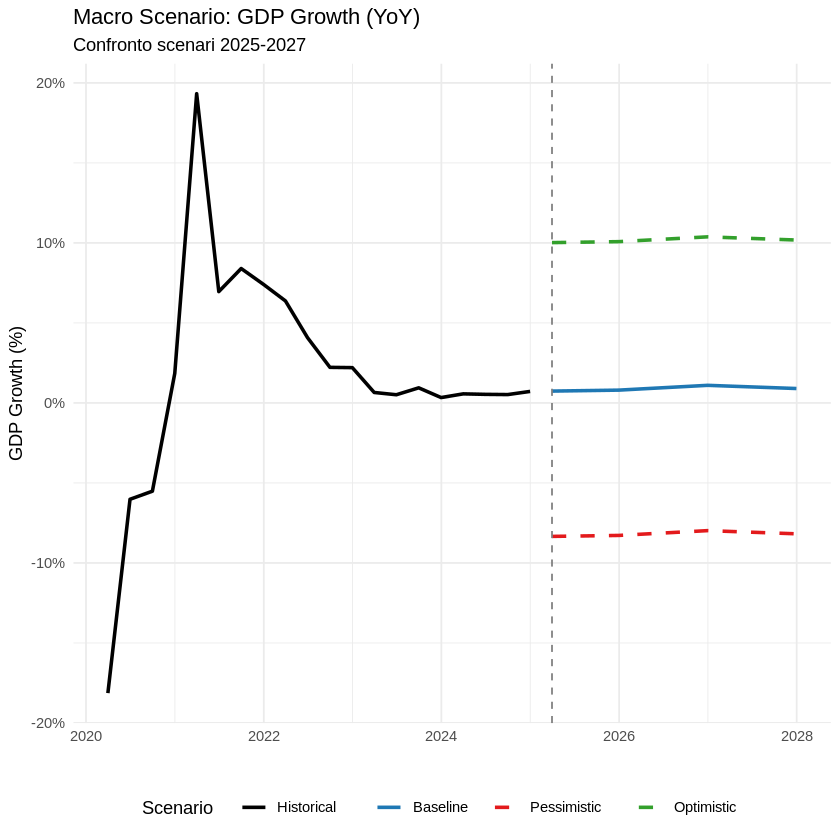

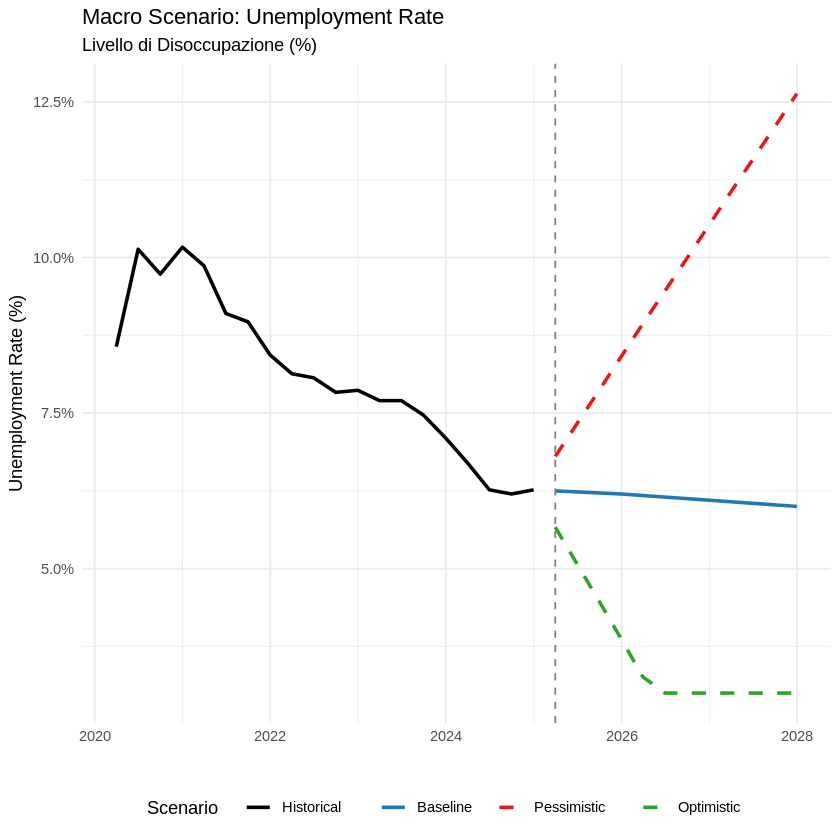

In [ ]:
library(ggplot2)
library(dplyr)
library(scales)

# =============================================================================
# 1. PREPARAZIONE DATI PER I GRAFICI
# =============================================================================

# A. Ricostruzione Livelli Disoccupazione
reconstruct_level <- function(start_val, diff_series) {
  levels <- numeric(length(diff_series))
  curr <- start_val
  for(i in 1:length(diff_series)) {
    curr <- curr + diff_series[i]
    levels[i] <- curr
  }
  return(levels)
}

last_hist_unemp <- tail(df_model_ready$Unemployment, 1)

# Aggiorniamo le colonne
scenario_base$Unemployment <- reconstruct_level(last_hist_unemp, scenario_base$D_Unemployment)
scenario_pess$Unemployment <- reconstruct_level(last_hist_unemp, scenario_pess$D_Unemployment)
scenario_opt$Unemployment  <- reconstruct_level(last_hist_unemp, scenario_opt$D_Unemployment)

# B. Unione dei Dataset (CON FIX dplyr::select)
hist_plot <- df_model_ready %>%
  filter(Date >= as.Date("2020-01-01")) %>%
  dplyr::select(Date, GDP_YoY, Unemployment) %>%   # <--- QUI LA CORREZIONE
  mutate(Scenario = "Historical")

base_plot <- scenario_base %>%
  dplyr::select(Date, GDP_YoY, Unemployment) %>%   # <--- QUI LA CORREZIONE
  mutate(Scenario = "Baseline")

pess_plot <- scenario_pess %>%
  dplyr::select(Date, GDP_YoY, Unemployment) %>%   # <--- QUI LA CORREZIONE
  mutate(Scenario = "Pessimistic")

opt_plot  <- scenario_opt  %>%
  dplyr::select(Date, GDP_YoY, Unemployment) %>%   # <--- QUI LA CORREZIONE
  mutate(Scenario = "Optimistic")

# Uniamo tutto
plot_data_macro <- bind_rows(hist_plot, base_plot, pess_plot, opt_plot)

# Ordiniamo i fattori
plot_data_macro$Scenario <- factor(plot_data_macro$Scenario,
                                   levels = c("Historical", "Baseline", "Pessimistic", "Optimistic"))

# Colori
my_colors <- c("Historical" = "black",
               "Baseline"   = "#1f78b4",
               "Pessimistic"= "#e31a1c",
               "Optimistic" = "#33a02c")

# =============================================================================
# 2. GRAFICO GDP GROWTH
# =============================================================================

g1 <- ggplot(plot_data_macro, aes(x = Date, y = GDP_YoY, color = Scenario, linetype = Scenario)) +
  geom_line(size = 1) +
  geom_vline(xintercept = as.numeric(min(scenario_base$Date)), linetype="dashed", color="grey50") +
  scale_color_manual(values = my_colors) +
  scale_linetype_manual(values = c("solid", "solid", "dashed", "dashed")) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Macro Scenario: GDP Growth (YoY)",
    subtitle = "Confronto scenari 2025-2027",
    y = "GDP Growth (%)",
    x = ""
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

print(g1)

# =============================================================================
# 3. GRAFICO UNEMPLOYMENT RATE
# =============================================================================

g2 <- ggplot(plot_data_macro, aes(x = Date, y = Unemployment, color = Scenario, linetype = Scenario)) +
  geom_line(size = 1) +
  geom_vline(xintercept = as.numeric(min(scenario_base$Date)), linetype="dashed", color="grey50") +
  scale_color_manual(values = my_colors) +
  scale_linetype_manual(values = c("solid", "solid", "dashed", "dashed")) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 0.1)) +
  labs(
    title = "Macro Scenario: Unemployment Rate",
    subtitle = "Livello di Disoccupazione (%)",
    y = "Unemployment Rate (%)",
    x = ""
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

print(g2)

In [ ]:
###########################################################################

#PROIEZIONI

##########################################################################
library(dplyr)
library(readxl)
library(ggplot2)
library(scales)

print("################################################################")
print("###   RIPARAZIONE FINALE E PROIEZIONI                        ###")
print("################################################################")

# -----------------------------------------------------------------------------
# 1. RECUPERO COEFFICIENTI (IL FIX PER L'ERRORE "LIST")
# -----------------------------------------------------------------------------
# Trasformiamo la colonna dei coefficienti in un vettore numerico PURO.
# Questo risolve l'errore: "list cannot be coerced to type double"
coeffs_vec <- as.numeric(bma_results$Weighted_Coeff)
names(coeffs_vec) <- bma_results$Term

print("Verifica Coefficienti (Deve dire 'numeric'):")
print(class(coeffs_vec))
print(head(coeffs_vec))

# -----------------------------------------------------------------------------
# 2. FIX DATI STORICI (RECUPERO DEFAULT RATE)
# -----------------------------------------------------------------------------
# Ricarichiamo il file originale per essere sicuri al 100% di avere la colonna Default_Rate
df_source <-read_excel( "Macroeconomic satellite Model.xlsx")

#Rinomina veloce delle prime due colonne (Date, DR)
colnames(df_source)[1:2] <- c("Date", "Default_Rate")
df_source$Date <- as.Date(df_source$Date, format = "%d/%m/%Y")

# Uniamo al dataset del modello (rimuovendo vecchia colonna DR se esiste per evitare duplicati)
if("Default_Rate" %in% colnames(df_model_ready)) df_model_ready$Default_Rate <- NULL
df_model_ready <- merge(df_model_ready, df_source[, c("Date", "Default_Rate")], by="Date", all.x=TRUE)
df_model_ready <- df_model_ready[order(df_model_ready$Date), ]

# -----------------------------------------------------------------------------
# 3. FUNZIONE PROIEZIONE
# -----------------------------------------------------------------------------
run_projection_safe <- function(scenario_future, history_df, model_coeffs) {

  # Convertiamo tutto in data.frame standard per evitare conflitti
  scenario_future <- as.data.frame(scenario_future)
  history_df      <- as.data.frame(history_df)

  cols_needed <- c("Date", "Default_Rate", "GDP_YoY", "D_Unemployment",
                   "D_CPI_YoY", "D_RPI_YoY", "D_BTP_10Y")

  # Inizializza Default Rate futuro come NA numerico
  if(!"Default_Rate" %in% colnames(scenario_future)) {
    scenario_future$Default_Rate <- as.numeric(NA)
  }

  # Unione Storico + Futuro
  cols_hist <- intersect(colnames(history_df), cols_needed)
  full_data <- bind_rows(history_df[, cols_hist], scenario_future[, cols_needed])
  full_data <- as.data.frame(full_data)

  # Calcolo Z storico
  full_data$Z_Index <- log(full_data$Default_Rate / (1 - full_data$Default_Rate))

  start_idx <- nrow(history_df) + 1
  end_idx   <- nrow(full_data)

  # LOOP TRIMESTRALE
  for(i in start_idx:end_idx) {

    # Intercetta
    z_val <- 0
    if("(Intercept)" %in% names(model_coeffs)) {
      z_val <- model_coeffs[["(Intercept)"]]
    }

    for(term in names(model_coeffs)) {
      if(term == "(Intercept)") next

      coef_val <- model_coeffs[[term]]
      if(coef_val == 0) next

      if(!grepl("_Lag", term)) {
        # --- Variabile Contemporanea ---
        val_macro <- full_data[i, term]
        z_val <- z_val + (coef_val * val_macro)
      } else {
        # --- Variabile Laggata ---
        parts <- strsplit(term, "_Lag")[[1]]
        var_name <- parts[1]
        lag_num  <- as.numeric(parts[2])

        # Fix nome: se il coeff si chiama Z_Lag1, cerchiamo la colonna Z_Index
        if(var_name == "Z") var_name <- "Z_Index"

        # Recupero valore passato
        val_lagged <- full_data[i - lag_num, var_name]
        z_val <- z_val + (coef_val * val_lagged)
      }
    }

    # Salvataggio
    full_data[i, "Z_Index"] <- z_val
    full_data[i, "Default_Rate"] <- 1 / (1 + exp(-z_val))
  }

  return(full_data[start_idx:end_idx, c("Date", "Default_Rate")])
}


[1] "################################################################"
[1] "###   RIPARAZIONE FINALE E PROIEZIONI                        ###"
[1] "################################################################"
[1] "Verifica Coefficienti (Deve dire 'numeric'):"
[1] "numeric"
 (Intercept)       Z_Lag1       Z_Lag2       Z_Lag3      GDP_YoY GDP_YoY_Lag1 
   -0.163140     1.281605    -0.054949    -0.268359    -0.351506    -0.380746 


[1] "Calcolo Proiezioni in corso..."
[1] "Esempio Proiezione Base:"
         Date Default_Rate
75 2025-03-31   0.01129332
76 2025-07-01   0.01156423
77 2025-10-01   0.01190478
78 2025-12-31   0.01230244
79 2026-03-31   0.01272677
80 2026-07-01   0.01315842
[1] "--- TABLE PREVISIONI DEFAULT RATE ---"
    Quarter Baseline Adverse Optimistic
1  2025-Q%q    1.13%   1.16%      1.10%
2  2025-Q%q    1.16%   1.27%      1.05%
3  2025-Q%q    1.19%   1.47%      0.96%
4  2025-Q%q    1.23%   1.66%      0.90%
5  2026-Q%q    1.27%   1.94%      0.82%
6  2026-Q%q    1.32%   2.28%      0.74%
7  2026-Q%q    1.36%   2.67%      0.66%
8  2026-Q%q    1.40%   3.11%      0.61%
9  2027-Q%q    1.43%   3.60%      0.58%
10 2027-Q%q    1.47%   4.12%      0.57%
11 2027-Q%q    1.50%   4.66%      0.58%
12 2027-Q%q    1.53%   5.21%      0.59%


Warning message in scale_x_date():
“A <numeric> value was passed to a Date scale.
ℹ The value was converted to a <Date> object.”


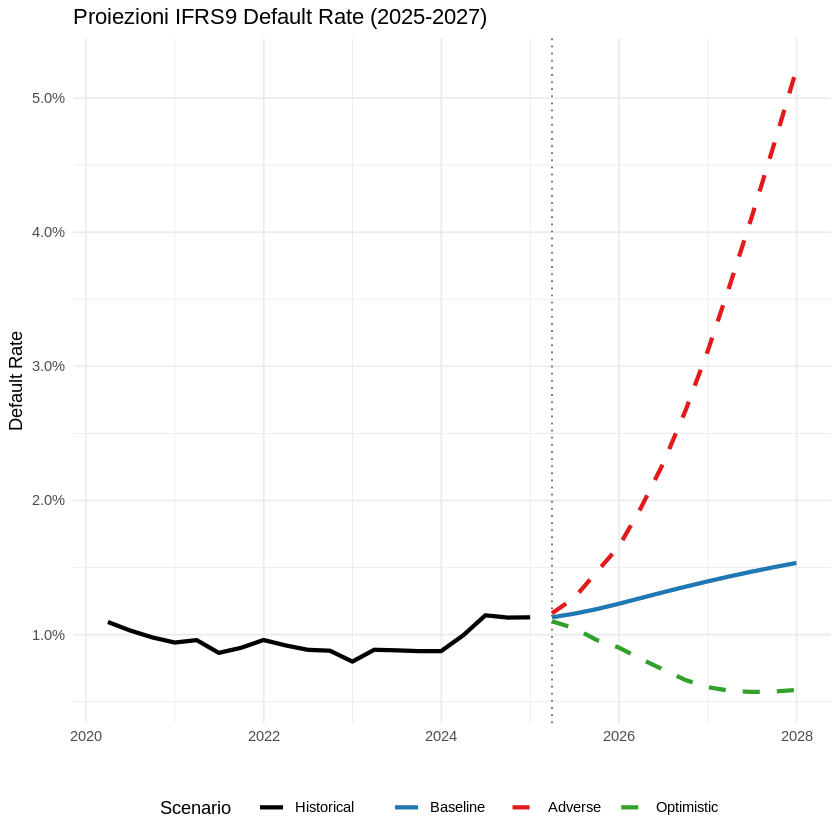

In [ ]:
# -----------------------------------------------------------------------------
# 4. ESECUZIONE
# -----------------------------------------------------------------------------
print("Calcolo Proiezioni in corso...")
proj_base <- run_projection_safe(scenario_base, df_model_ready, coeffs_vec)
proj_pess <- run_projection_safe(scenario_pess, df_model_ready, coeffs_vec)
proj_opt  <- run_projection_safe(scenario_opt,  df_model_ready, coeffs_vec)

print("Esempio Proiezione Base:")
print(head(proj_base))

# -----------------------------------------------------------------------------
# 5. TABLE FORECAST (View Console)
# -----------------------------------------------------------------------------
final_view <- data.frame(
  Quarter = format(proj_base$Date, "%Y-Q%q"),
  Baseline   = percent(proj_base$Default_Rate, accuracy = 0.01),
  Adverse    = percent(proj_pess$Default_Rate, accuracy = 0.01),
  Optimistic = percent(proj_opt$Default_Rate, accuracy = 0.01)
)
print("--- TABLE PREVISIONI DEFAULT RATE ---")
print(final_view)

# -----------------------------------------------------------------------------
# 6. GRAFICO FINALE (FAN CHART)
# -----------------------------------------------------------------------------
proj_base$Scenario <- "Baseline"
proj_pess$Scenario <- "Adverse"
proj_opt$Scenario  <- "Optimistic"

# Storico dal 2020
hist_plot <- df_model_ready %>%
  filter(Date >= as.Date("2020-01-01")) %>%
  dplyr::select(Date, Default_Rate) %>%
  mutate(Scenario = "Historical")

plot_data <- bind_rows(hist_plot, proj_base, proj_pess, proj_opt)
plot_data$Scenario <- factor(plot_data$Scenario, levels = c("Historical", "Baseline", "Adverse", "Optimistic"))

cols <- c("Historical"="black", "Baseline"="#1f78b4", "Adverse"="#e31a1c", "Optimistic"="#33a02c")

p <- ggplot(plot_data, aes(x=Date, y=Default_Rate, color=Scenario, group=Scenario)) +
  geom_line(aes(linetype=Scenario), size=1.2) +
  geom_vline(xintercept = as.numeric(min(proj_base$Date)), linetype="dotted", color="gray40") +
  scale_color_manual(values=cols) +
  scale_linetype_manual(values=c("solid", "solid", "dashed", "dashed")) +
  scale_y_continuous(labels = percent_format(accuracy=0.1)) +
  labs(title="Proiezioni IFRS9 Default Rate (2025-2027)", y="Default Rate", x="") +
  theme_minimal() +
  theme(legend.position="bottom")

print(p)

[1] "--- Generazione Grafico Finale ---"


Warning message in scale_x_date(date_breaks = "1 year", date_labels = "%Y"):
“A <numeric> value was passed to a Date scale.
ℹ The value was converted to a <Date> object.”


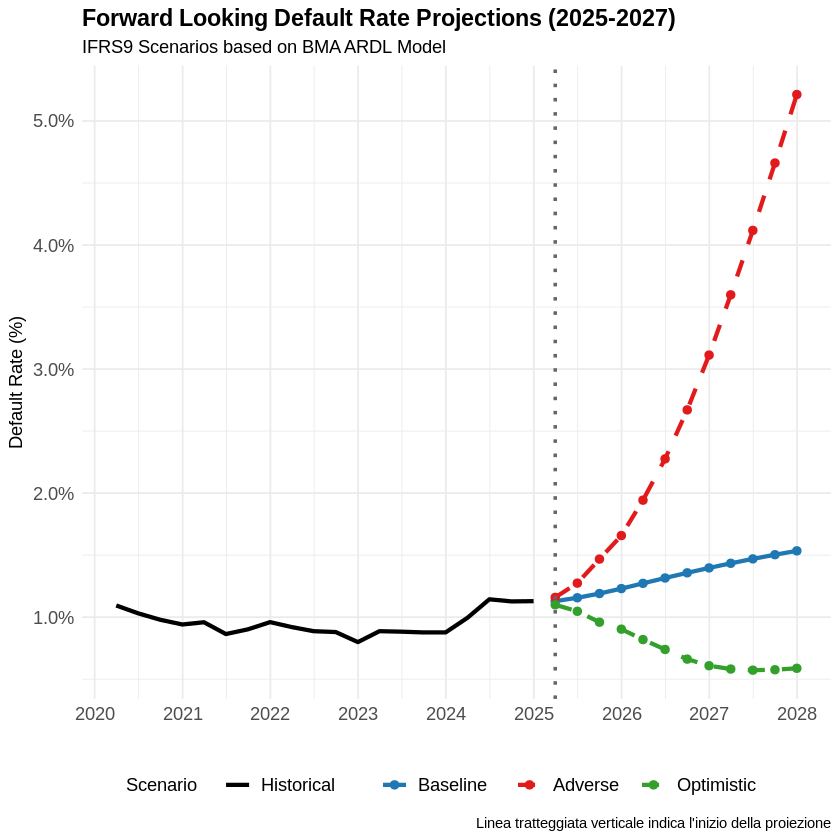

In [ ]:
# =============================================================================
# GRAFICO FINALE CORRETTO: IFRS9 FAN CHART
# =============================================================================

print("--- Generazione Grafico Finale ---")

# 1. PREPARAZIONE DATI
# Aggiungiamo l'etichetta "Scenario" a ogni dataset proiettato
proj_base$Scenario <- "Baseline"
proj_pess$Scenario <- "Adverse"
proj_opt$Scenario  <- "Optimistic"

# Prendiamo un pezzo di storia per dare contesto (es. dal 2020 in poi)
# USIAMO dplyr::select PER EVITARE L'ERRORE
hist_plot <- df_model_ready %>%
  filter(Date >= as.Date("2020-01-01")) %>%
  dplyr::select(Date, Default_Rate) %>%   # <--- QUI LA CORREZIONE
  mutate(Scenario = "Historical")

# Uniamo tutto in un unico dataframe per ggplot
plot_data <- bind_rows(hist_plot, proj_base, proj_pess, proj_opt)

# Ordiniamo i livelli della legenda
plot_data$Scenario <- factor(plot_data$Scenario,
                             levels = c("Historical", "Baseline", "Adverse", "Optimistic"))

# 2. DEFINIZIONE COLORI E STILI
my_colors <- c(
  "Historical" = "black",
  "Baseline"   = "#1f78b4", # Blu scuro
  "Adverse"    = "#e31a1c", # Rosso acceso
  "Optimistic" = "#33a02c"  # Verde acceso
)

# 3. CREAZIONE GRAFICO
p <- ggplot(plot_data, aes(x = Date, y = Default_Rate, color = Scenario, group = Scenario)) +

  # A. Linee principali
  geom_line(aes(linetype = Scenario), size = 1.2) +

  # B. Punti sui dati futuri
  geom_point(data = subset(plot_data, Scenario != "Historical"), size = 2) +

  # C. Linea verticale separatore
  geom_vline(xintercept = as.numeric(min(proj_base$Date)),
             linetype = "dotted", color = "gray40", size = 1) +

  # D. Gestione Colori e Tratteggi
  scale_color_manual(values = my_colors) +
  scale_linetype_manual(values = c("solid", "solid", "dashed", "dashed")) +

  # E. Formattazione Assi (Percentuali)
  scale_y_continuous(labels = scales::percent_format(accuracy = 0.1)) +
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") +

  # F. Etichette e Titoli
  labs(
    title = "Forward Looking Default Rate Projections (2025-2027)",
    subtitle = "IFRS9 Scenarios based on BMA ARDL Model",
    y = "Default Rate (%)",
    x = "",
    caption = "Linea tratteggiata verticale indica l'inizio della proiezione"
  ) +

  # G. Tema pulito
  theme_minimal() +
  theme(
    legend.position = "bottom",
    plot.title = element_text(face = "bold", size = 14),
    axis.text = element_text(size = 11),
    legend.text = element_text(size = 11)
  )

# Mostra il grafico
print(p)

In [ ]:
print("############################################################")
print("###      PROIEZIONI DEFAULT RATE (2025 - 2027)           ###")
print("############################################################")

library(dplyr)
library(scales)


# 1. Creiamo una tabella unica che unisce i tre scenari
final_projection_table <- data.frame(
  Date = proj_base$Date,
  Baseline_Raw   = proj_base$Default_Rate,
  Adverse_Raw    = proj_pess$Default_Rate,
  Optimistic_Raw = proj_opt$Default_Rate
)

# 2. Creiamo una versione "View" formattata per la lettura umana
view_table <- final_projection_table %>%
  mutate(
    # Formattiamo la data come Anno-Trimestre (es. 2025-Q1)
    Quarter = format(Date, "%Y-Q%q"),

    # Formattiamo i numeri in Percentuale con 2 decimali
    Baseline   = percent(Baseline_Raw, accuracy = 0.01),
    Adverse    = percent(Adverse_Raw, accuracy = 0.01),    # Scenario Pessimistico
    Optimistic = percent(Optimistic_Raw, accuracy = 0.01)  # Scenario Ottimistico
  ) %>%
  # Selezioniamo solo le colonne belle da vedere
  dplyr::select(Quarter, Baseline, Adverse, Optimistic)

# 3. STAMPA DELLA TABELLA
print(view_table)

# 4. (Opzionale) Salva su CSV se ti serve inviarlo
# write.csv(view_table, "Proiezioni_Finali_DefaultRate.csv", row.names = FALSE)

[1] "############################################################"
[1] "###      PROIEZIONI DEFAULT RATE (2025 - 2027)           ###"
[1] "############################################################"
    Quarter Baseline Adverse Optimistic
1  2025-Q%q    1.13%   1.16%      1.10%
2  2025-Q%q    1.16%   1.27%      1.05%
3  2025-Q%q    1.19%   1.47%      0.96%
4  2025-Q%q    1.23%   1.66%      0.90%
5  2026-Q%q    1.27%   1.94%      0.82%
6  2026-Q%q    1.32%   2.28%      0.74%
7  2026-Q%q    1.36%   2.67%      0.66%
8  2026-Q%q    1.40%   3.11%      0.61%
9  2027-Q%q    1.43%   3.60%      0.58%
10 2027-Q%q    1.47%   4.12%      0.57%
11 2027-Q%q    1.50%   4.66%      0.58%
12 2027-Q%q    1.53%   5.21%      0.59%


In [ ]:
library(dplyr)
library(ggplot2)

print("############################################################")
print("###      CALCOLO FATTORE SISTEMICO Z (Z-SHIFT)           ###")
print("############################################################")

# =============================================================================
# 1. CALCOLO PARAMETRI STORICI (LRA e RHO)
# =============================================================================

# Prendiamo la serie storica dei Default Rate
hist_dr <- df_model_ready$Default_Rate

# Pulizia: Rimuoviamo 0 o 1 esatti per evitare infiniti nel calcolo probit
hist_dr_clean <- hist_dr[hist_dr > 0 & hist_dr < 1]

# A. Calcolo LRA (Long Run Average)
LRA <- mean(hist_dr_clean, na.rm = TRUE)

# B. Calcolo Sigma^2 e Rho (Correlazione)
# Trasformazione Probit (Inverse Normal)
probit_dr <- qnorm(hist_dr_clean)
sigma_sq  <- var(probit_dr, na.rm = TRUE)

# Calcolo Rho (Formula: rho = sigma^2 / (1 + sigma^2))
rho <- sigma_sq / (1 + sigma_sq)

print(paste("LRA (Media Storica):", percent(LRA, 0.01)))
print(paste("Rho (Correlazione): ", round(rho, 5)))

# =============================================================================
# 2. FUNZIONE DI CALCOLO Z (Z-SHIFT)
# =============================================================================

calculate_z_factor <- function(scenario_df, lra_val, rho_val) {

  # Prendiamo i Default Rate dello scenario
  odr_t <- scenario_df$Default_Rate

  # Clip di sicurezza (per evitare errori matematici se DR è 0 o 1)
  odr_t <- pmax(0.0001, pmin(0.9999, odr_t))

  # --- APPLICAZIONE FORMULA 3.12.1 ---
  # Z_t = [ qnorm(LRA) - qnorm(ODR_t) * sqrt(1-rho) ] / sqrt(rho)

  term_lra <- qnorm(lra_val)
  term_odr <- qnorm(odr_t) * sqrt(1 - rho_val)

  Z_t <- (term_lra - term_odr) / sqrt(rho_val)

  # Aggiungiamo la colonna al dataframe
  scenario_df$Systemic_Z <- Z_t

  return(scenario_df)
}

[1] "############################################################"
[1] "###      CALCOLO FATTORE SISTEMICO Z (Z-SHIFT)           ###"
[1] "############################################################"
[1] "LRA (Media Storica): 2.33%"
[1] "Rho (Correlazione):  0.05692"


In [ ]:
# =============================================================================
# 3. APPLICAZIONE AGLI SCENARI
# =============================================================================

# Calcoliamo Z per i tre scenari futuri
z_base <- calculate_z_factor(proj_base, LRA, rho)
z_pess <- calculate_z_factor(proj_pess, LRA, rho)
z_opt  <- calculate_z_factor(proj_opt,  LRA, rho)

# Uniamo per visualizzare
z_base$Scenario <- "Baseline"
z_pess$Scenario <- "Adverse"
z_opt$Scenario  <- "Optimistic"

# Creiamo anche lo Z storico per confronto
df_hist_z <- df_model_ready
df_hist_z$Scenario <- "Historical"
df_hist_z <- calculate_z_factor(df_hist_z, LRA, rho)
# Filtriamo dal 2020 in poi per il grafico
df_hist_z <- df_hist_z %>% filter(Date >= as.Date("2020-01-01"))

# Dataset unico
all_z_data <- bind_rows(
  df_hist_z[, c("Date", "Systemic_Z", "Scenario")],
  z_base[, c("Date", "Systemic_Z", "Scenario")],
  z_pess[, c("Date", "Systemic_Z", "Scenario")],
  z_opt[, c("Date", "Systemic_Z", "Scenario")]
)
all_z_data$Scenario <- factor(all_z_data$Scenario, levels = c("Historical", "Baseline", "Adverse", "Optimistic"))

Warning message in scale_x_date():
“A <numeric> value was passed to a Date scale.
ℹ The value was converted to a <Date> object.”


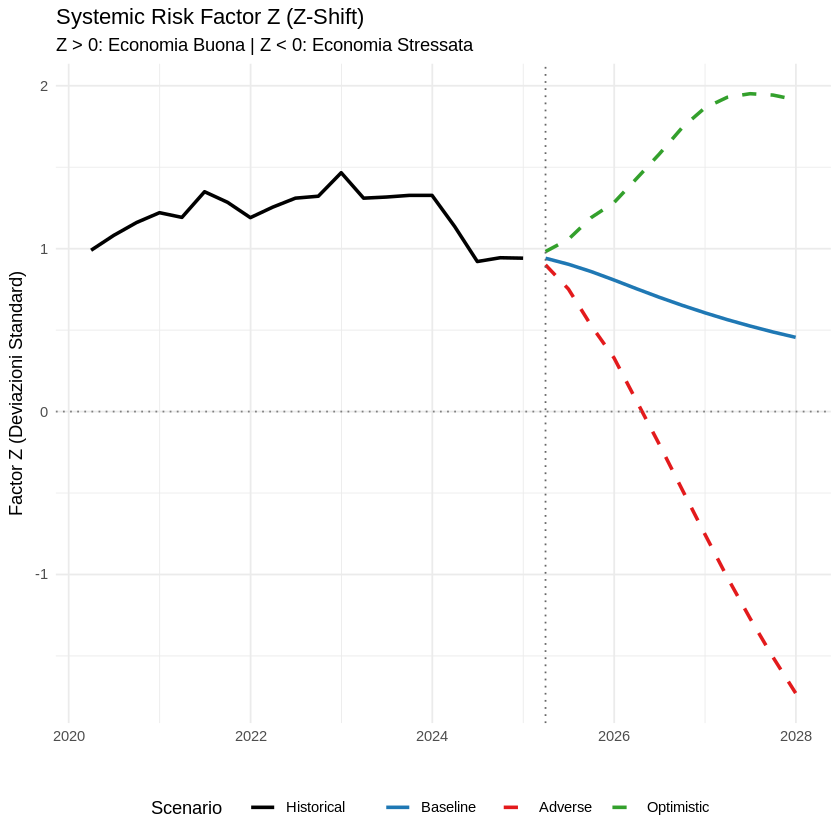

In [ ]:
# =============================================================================
# 4. GRAFICO FATTORE Z
# =============================================================================

cols <- c("Historical"="black", "Baseline"="#1f78b4", "Adverse"="#e31a1c", "Optimistic"="#33a02c")

p_z <- ggplot(all_z_data, aes(x=Date, y=Systemic_Z, color=Scenario, group=Scenario)) +
  geom_line(aes(linetype=Scenario), size=1) +
  geom_hline(yintercept=0, color="gray50", linetype="dotted") + # Linea dello zero
  geom_vline(xintercept = as.numeric(min(z_base$Date)), linetype="dotted", color="gray40") +
  scale_color_manual(values=cols) +
  scale_linetype_manual(values=c("solid", "solid", "dashed", "dashed")) +
  labs(
    title = "Systemic Risk Factor Z (Z-Shift)",
    subtitle = "Z > 0: Economia Buona | Z < 0: Economia Stressata",
    y = "Factor Z (Deviazioni Standard)",
    x = ""
  ) +
  theme_minimal() +
  theme(legend.position="bottom")

print(p_z)

In [ ]:
# =============================================================================
# 5. STAMPA TABELLA Z FUTURI
# =============================================================================
print("--- VALORI Z FUTURI (2025-2027) ---")
z_table <- data.frame(
  Quarter = format(z_base$Date, "%Y-Q%q"),
  Z_Baseline = round(z_base$Systemic_Z, 3),
  Z_Adverse  = round(z_pess$Systemic_Z, 3),
  Z_Optimistic = round(z_opt$Systemic_Z, 3)
)
print(z_table)

[1] "--- VALORI Z FUTURI (2025-2027) ---"
    Quarter Z_Baseline Z_Adverse Z_Optimistic
1  2025-Q%q      0.941     0.900        0.982
2  2025-Q%q      0.904     0.752        1.058
3  2025-Q%q      0.859     0.527        1.192
4  2025-Q%q      0.808     0.330        1.283
5  2026-Q%q      0.754     0.067        1.429
6  2026-Q%q      0.702    -0.201        1.581
7  2026-Q%q      0.652    -0.479        1.743
8  2026-Q%q      0.607    -0.752        1.864
9  2027-Q%q      0.564    -1.017        1.929
10 2027-Q%q      0.525    -1.270        1.951
11 2027-Q%q      0.489    -1.508        1.943
12 2027-Q%q      0.456    -1.728        1.914
